In [1]:
import os 
os.chdir('/Users/marcs')

In [30]:
import matplotlib.pyplot as plt
from pickle_loader import pickle_loader
import datetime as dt
import pandas as pd
import pickle


In [3]:
balence_sheet = pickle_loader('/Users/marcs/OneDrive/Documents/stock_analysis2/quarterly_balance_sheet_us.pickle')
income_statement = pickle_loader('/Users/marcs/OneDrive/Documents/stock_analysis2/quarterly_income_stmt_us.pickle')
cash_flow = pickle_loader('/Users/marcs/OneDrive/Documents/stock_analysis2/quarterly_cashflow_us.pickle')

## Find empty tickers

In [4]:
tickers = list(balence_sheet.keys())

In [5]:
empty_tickers_bs = [ticker for ticker in tickers if len(balence_sheet[ticker]) == 0]
empty_tickers_is = [ticker for ticker in tickers if len(income_statement[ticker]) == 0]
empty_tickers_cf = [ticker for ticker in tickers if len(cash_flow[ticker]) == 0]

In [6]:
print(empty_tickers_bs, empty_tickers_is, empty_tickers_cf)

['BRK.B', 'BF.B', 'RE', 'FISV', 'PKI'] ['BRK.B', 'BF.B', 'RE', 'FISV', 'PKI'] ['BRK.B', 'BF.B', 'RE', 'FISV', 'PKI']


In [7]:
empty_tickers = set(empty_tickers_bs + empty_tickers_is + empty_tickers_cf)

In [8]:
empty_tickers

{'BF.B', 'BRK.B', 'FISV', 'PKI', 'RE'}

In [9]:
for empty in empty_tickers:
    balence_sheet.pop(empty, None)
    income_statement.pop(empty, None)
    cash_flow.pop(empty, None)

In [10]:
set(balence_sheet['MMM'].index)

{'Accounts Payable',
 'Accounts Receivable',
 'Accumulated Depreciation',
 'Additional Paid In Capital',
 'Allowance For Doubtful Accounts Receivable',
 'Buildings And Improvements',
 'Capital Lease Obligations',
 'Capital Stock',
 'Cash And Cash Equivalents',
 'Cash Cash Equivalents And Short Term Investments',
 'Common Stock',
 'Common Stock Equity',
 'Construction In Progress',
 'Current Accrued Expenses',
 'Current Assets',
 'Current Capital Lease Obligation',
 'Current Debt',
 'Current Debt And Capital Lease Obligation',
 'Current Deferred Liabilities',
 'Current Deferred Revenue',
 'Current Liabilities',
 'Defined Pension Benefit',
 'Employee Benefits',
 'Finished Goods',
 'Gains Losses Not Affecting Retained Earnings',
 'Goodwill',
 'Goodwill And Other Intangible Assets',
 'Gross Accounts Receivable',
 'Gross PPE',
 'Hedging Assets Current',
 'Income Tax Payable',
 'Inventory',
 'Invested Capital',
 'Investmentin Financial Assets',
 'Investments And Advances',
 'Land And Improve

## Find number stock with a given attribute 

Each stock is compossed of a number of attributes for each class of fundemental data (these are income statement, cash flow and balence sheet). In this section I will find the number of stocks for each given attribute.

In [11]:
class fundamental_attr():
    
    def __init__(self, dict_fundamental_data):
        all_ticker_attr = set(dict_fundamental_data[list(dict_fundamental_data.keys())[0]].index) # This set will get updated as we loop through the tickers 
        
        for ticker, data in dict_fundamental_data.items():
            ticker_attr = set(data.index)
            all_ticker_attr.update(ticker_attr)
        
        self.set_fundamental_attr = all_ticker_attr
        self.dict_fundamental_data = dict_fundamental_data
    
    def get_count_fundamental_attr(self):
        dict_fundamental_data = self.dict_fundamental_data
        set_fundamental_attr = self.set_fundamental_attr
        
        all_attr_count = {attr : 0 for attr in set_fundamental_attr}
    
        for ticker, data in dict_fundamental_data.items():
            ticker_attr = list(data.index)
            
            for attr in set_fundamental_attr:
                count_attr = ticker_attr.count(attr)
                all_attr_count[attr] += count_attr
        
        self.all_attr_count = all_attr_count
        
        return all_attr_count
    
    def find_attr_above_percentage(self, percentage):
        all_attr_count = self.all_attr_count
        dict_fundamental_data = self.dict_fundamental_data
        
        number_of_stocks = len(list(dict_fundamental_data.keys()))
        
        attr_below_percentage = {attr for attr, count in all_attr_count.items() if ((count / number_of_stocks) *  100) >= percentage}
        
        return attr_below_percentage
        
        
        


In [12]:
bs_fundamental_attr = fundamental_attr(balence_sheet)
count_bs_attr = bs_fundamental_attr.get_count_fundamental_attr()

is_fundamental_attr = fundamental_attr(income_statement)
count_is_attr = is_fundamental_attr.get_count_fundamental_attr()

cf_fundamental_attr = fundamental_attr(cash_flow)
count_cf_attr = cf_fundamental_attr.get_count_fundamental_attr()

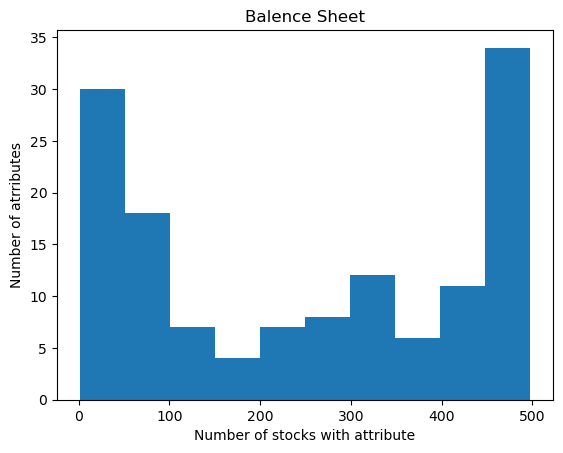

In [13]:
plt.hist(count_bs_attr.values(), bins = 10, density = False)
plt.xlabel('Number of stocks with attribute')
plt.ylabel('Number of atrributes')
plt.title('Balence Sheet')
plt.show()

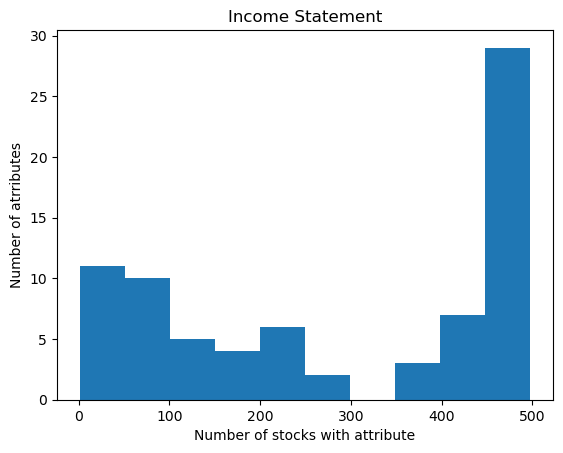

In [14]:
plt.hist(count_is_attr.values(), bins = 10, density = False)
plt.xlabel('Number of stocks with attribute')
plt.ylabel('Number of atrributes')
plt.title('Income Statement')
plt.show()

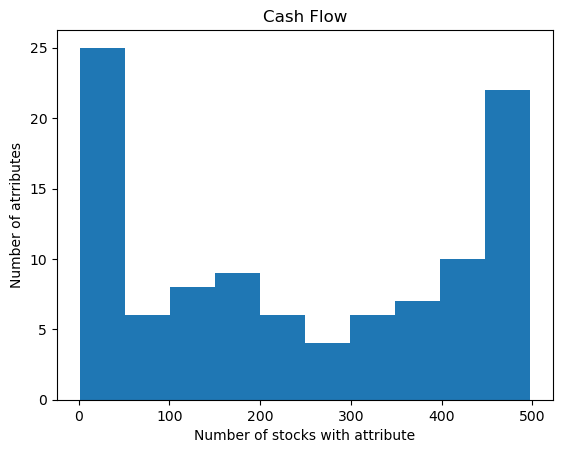

In [15]:
plt.hist(count_cf_attr.values(), bins = 10, density = False)
plt.xlabel('Number of stocks with attribute')
plt.ylabel('Number of atrributes')
plt.title('Cash Flow')
plt.show()

For each class of fundemtal data there are least 40 attributes which are present in over 400 stocks. I will remove the attributes with under 400 stocks present as there is not enough data on these attributes to make predictions on. So, 80% of the attributes will be removed. I will name the attributes I keep as modeling attributes.

It is worth noting that some of current modeling attributes are missing data for some of the quarters. So, in the section I will remove the attributes from the modeling attributes which don't have 4 quarters worth of data.

In [16]:
modeling_attributes = bs_fundamental_attr.find_attr_above_percentage(80)
modeling_attributes.update(is_fundamental_attr.find_attr_above_percentage(80))
modeling_attributes.update(cf_fundamental_attr.find_attr_above_percentage(80))
print('The number of modeling attributes is:', len(modeling_attributes))

The number of modeling attributes is: 113


In [17]:
# First we will need a function which the 3 classes of fundemental data together

def merge_fundemental(dict_bs, dict_is, dict_cf):
    tickers = dict_bs.keys()
    dict_fund = {}
    
    for ticker in tickers:
        quarterly_bs = dict_bs[ticker]
        quarterly_is = dict_is[ticker]
        quarterly_cf = dict_cf[ticker]
        
        lst_of_quarterly = [quarterly_bs, quarterly_is, quarterly_cf]
        
        combinded_fund = pd.concat(lst_of_quarterly)
        
        dict_fund[ticker] = combinded_fund
        
    return dict_fund
    

In [18]:
# Function which outputs the count of full quarterally datasets for a given modeling attribute

def missing_quaterally(set_attr, dict_fundamental_data):
    
    tickers = dict_fundamental_data.keys()
    count_full = {attr : 0 for attr in set_attr}
    
    for ticker in tickers:
        data = dict_fundamental_data[ticker]
        ticker_attr = set(data.index)
        set_attr_ticker = set_attr.intersection(ticker_attr)
        
        for attr in set_attr_ticker:
            any_na = data.loc[attr].isna().any()
            
            if any_na == False:
                count_full[attr] += 1
    
    return count_full 

In [19]:
fundamental_data = merge_fundemental(balence_sheet, income_statement, cash_flow)

In [20]:
count_full_attr = missing_quaterally(modeling_attributes, fundamental_data)

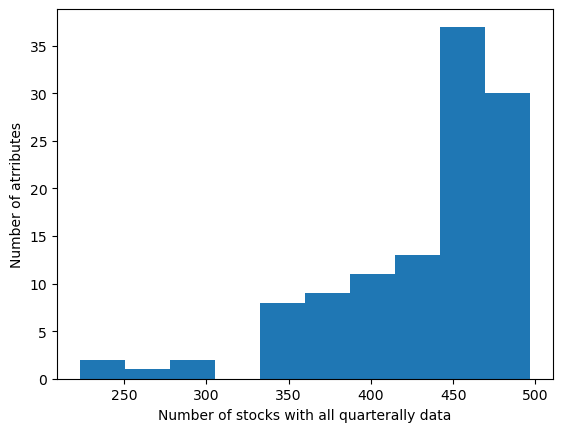

In [21]:
plt.hist(count_full_attr.values(), bins = 10, density = False)
plt.xlabel('Number of stocks with all quarterally data')
plt.ylabel('Number of atrributes')
plt.show()

There are around 60 attributes which contain 450 stocks of full data. These attributes will become my final set of modeling attributes.

In [22]:
modeling_attributes = {attr for attr in count_full_attr.keys() if count_full_attr[attr] >= 450}
print('The number modeling attributes is: ', len(modeling_attributes))
modeling_attributes

The number modeling attributes is:  62


{'Accounts Receivable',
 'Basic Average Shares',
 'Basic EPS',
 'Beginning Cash Position',
 'Capital Expenditure',
 'Capital Stock',
 'Cash And Cash Equivalents',
 'Cash Cash Equivalents And Short Term Investments',
 'Cash Flow From Continuing Financing Activities',
 'Cash Flow From Continuing Investing Activities',
 'Cash Flow From Continuing Operating Activities',
 'Change In Working Capital',
 'Changes In Cash',
 'Common Stock',
 'Common Stock Equity',
 'Current Assets',
 'Current Liabilities',
 'Diluted Average Shares',
 'Diluted EPS',
 'Diluted NI Availto Com Stockholders',
 'EBIT',
 'End Cash Position',
 'Financing Cash Flow',
 'Free Cash Flow',
 'Gains Losses Not Affecting Retained Earnings',
 'Invested Capital',
 'Investing Cash Flow',
 'Long Term Debt',
 'Long Term Debt And Capital Lease Obligation',
 'Net Income',
 'Net Income Common Stockholders',
 'Net Income Continuous Operations',
 'Net Income From Continuing And Discontinued Operation',
 'Net Income From Continuing Opera

## Find stocks to remove 

The 100 stocks without the modeling attributes I have kept will either be removed or have their values predicted using the MICE algorithim. Whether or not a stock is removed as this stage is dependent on:

1) That for each modeling attribute that the stock does have. There is no missing data for any quarter.

2) That there are enough remaining modeling attributes to accurately use the MICE algorihtm to infer the missing attributes value.

In [23]:
test_ticker = list(fundamental_data.keys())[0]
fundamental_data[test_ticker]

,2023-06-30,2023-03-31,2022-12-31,2022-09-30
Treasury Shares Number,392040626.0,392360839.0,394787951.0,NaN
Ordinary Shares Number,551992430.0,551672217.0,549245105.0,552742915.0
Share Issued,944033056.0,944033056.0,944033056.0,552742915.0
Net Debt,11729000000.0,12136000000.0,12284000000.0,12301000000.0
Total Debt,16231000000.0,16223000000.0,16200000000.0,16516000000.0
...,...,...,...,...
Depreciation And Amortization,449000000.0,466000000.0,460000000.0,450000000.0
Operating Gains Losses,38000000.0,37000000.0,54000000.0,-2683000000.0
Pension And Employee Benefit Expense,38000000.0,37000000.0,54000000.0,41000000.0
Gain Loss On Sale Of Business,NaN,NaN,0.0,NaN


In [24]:
fundamental_data[test_ticker].loc['Treasury Shares Number'].isna().any()

True

In [54]:
class stock_removal():
    
    def __init__(self, modeling_attributes, fundamental_dict):
        self.modeling_attributes = modeling_attributes
        self.fundamental_dict = fundamental_dict
        
    def num_full_modeling_attributes(self):
        modeling_attributes = self.modeling_attributes
        fundamental_dict = self.fundamental_dict
        
        tickers = fundamental_dict.keys()
        count_full = {ticker : 0 for ticker in tickers}
    
        for ticker in tickers:
            data = fundamental_dict[ticker]
            ticker_attr = set(data.index)
            set_attr_ticker = modeling_attributes.intersection(ticker_attr) # Find set of modeling attr present in stock
        
            for attr in set_attr_ticker:
                any_na = data.loc[attr].isna().any()
            
                if any_na == False:
                    count_full[ticker] += 1
        
        self.count_full = count_full
    
        return count_full
    
    def final_fundamental_dict(self):
        fundamental_dict = self.fundamental_dict
        count_full = self.count_full
        
        final_tickers = [ticker for ticker in count_full.keys() if count_full[ticker] >= 50]
        
        final_fundamental_dict = {ticker : fundamental_dict[ticker] for ticker in final_tickers}
        
        print('The number of stocks removed: ', len(fundamental_dict) - len(final_fundamental_dict))
        
        return final_fundamental_dict
        

In [55]:
obj_stock_removal = stock_removal(modeling_attributes, fundamental_data)

In [56]:
count_full_modeling_attr = obj_stock_removal.num_full_modeling_attributes()

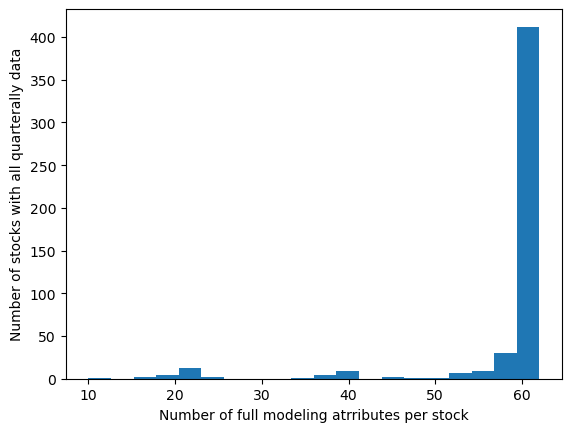

In [57]:
plt.hist(count_full_modeling_attr.values(), bins = 20, density = False)
plt.ylabel('Number of stocks with all quarterally data')
plt.xlabel('Number of full modeling atrributes per stock')
plt.show()

In [58]:
final_fundamental_dict = obj_stock_removal.final_fundamental_dict()

The number of stocks removed:  39


In [59]:
final_fundamental_dict['MMM']

,2023-06-30,2023-03-31,2022-12-31,2022-09-30
Treasury Shares Number,392040626.0,392360839.0,394787951.0,NaN
Ordinary Shares Number,551992430.0,551672217.0,549245105.0,552742915.0
Share Issued,944033056.0,944033056.0,944033056.0,552742915.0
Net Debt,11729000000.0,12136000000.0,12284000000.0,12301000000.0
Total Debt,16231000000.0,16223000000.0,16200000000.0,16516000000.0
...,...,...,...,...
Depreciation And Amortization,449000000.0,466000000.0,460000000.0,450000000.0
Operating Gains Losses,38000000.0,37000000.0,54000000.0,-2683000000.0
Pension And Employee Benefit Expense,38000000.0,37000000.0,54000000.0,41000000.0
Gain Loss On Sale Of Business,NaN,NaN,0.0,NaN


In [31]:
with open("/Users/marcs/OneDrive/Documents/stock_analysis2/final_fundamental_dict.pickle", 'wb') as f:
        pickle.dump(final_fundamental_dict, f)

In [60]:
with open("/Users/marcs/OneDrive/Documents/stock_analysis2/fundamental_modeling_attributes.pickle", 'wb') as f:
        pickle.dump(modeling_attributes, f)